In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

/Users/Jed.Homer/phd/numpyro_examples/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
truth = dict(
    mu_alpha=0.0,    # Mean of distribution alpha chosen from
    sigma_alpha=1.0, # Variance of distribution alpha chosen from
    mu_beta=2.0,     # Mean of distribution beta chosen from
    sigma_beta=0.5,  # Variance of distribution beta chosen from
    sigma_obs=0.3    # Observational data noise
)

In [ ]:
def simulate_hierarchical_regression(
    key,
    n_groups=8,
    n_obs_per_group=15,
    *,
    mu_alpha=0.0,
    sigma_alpha=1.0,
    mu_beta=2.0,
    sigma_beta=0.5,
    sigma_obs=0.3,
    x_low=-1.0,
    x_high=1.0,
):
    """
        Simulate a toy hierarchical linear regression dataset.

        Returns:
            x:         shape (N,)      – all x values
            y:         shape (N,)      – noisy observations
            group_idx: shape (N,)      – integer group code in [0, n_groups-1]
            true: dict – true parameters used to generate the data
    """
    key_alpha, key_beta, key_x, key_eps = jr.split(key, 4)

    # Sample group-specific intercepts and slopes (for this instance?)
    alpha = mu_alpha + sigma_alpha * jr.normal(key_alpha, (n_groups,))
    beta = mu_beta + sigma_beta * jr.normal(key_beta, (n_groups,))

    # Build per-group x, y
    N = n_groups * n_obs_per_group
    group_idx = jnp.repeat(jnp.arange(n_groups), n_obs_per_group)

    # Sample along x-axis and create mean (noiseless) line points
    x = jr.uniform(key_x, (N,), minval=x_low, maxval=x_high)
    mean = alpha[group_idx] + beta[group_idx] * x

    # Add some noise to the points
    eps = sigma_obs * jr.normal(key_eps, (N,))
    y = mean + eps

    true_params = {
        "mu_alpha": mu_alpha,
        "sigma_alpha": sigma_alpha,
        "mu_beta": mu_beta,
        "sigma_beta": sigma_beta,
        "sigma_obs": sigma_obs,
        "alpha": alpha,
        "beta": beta
    }

    return x, y, group_idx, true_params

In [4]:
def hierarchical_linear_model(group_idx, x, n_groups, y_obs=None):
    """
        group_idx : 1D int array of length N, values in [0, n_groups-1]
        x         : 1D array of predictors (same length as group_idx)
        y_obs     : 1D array of observations (same length), or None for prediction
    """
    # Hyperpriors for intercepts and slopes
    mu_alpha = numpyro.sample("mu_alpha", dist.Normal(0.0, 5.0))
    sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfNormal(2.0))

    mu_beta = numpyro.sample("mu_beta", dist.Normal(0.0, 5.0))
    sigma_beta = numpyro.sample("sigma_beta", dist.HalfNormal(2.0))

    # Group-level intercepts/slopes
    with numpyro.plate("groups", n_groups):
        alpha = numpyro.sample("alpha", dist.Normal(mu_alpha, sigma_alpha))
        beta = numpyro.sample("beta", dist.Normal(mu_beta, sigma_beta))

    # Observation noise
    sigma = numpyro.sample("sigma_obs", dist.HalfNormal(1.0))

    # Linear predictor per observation
    mean = alpha[group_idx] + beta[group_idx] * x

    # Likelihood
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=y_obs)

In [5]:
key = jr.key(0)

x, y, group_idx, true_params = simulate_hierarchical_regression(
    key,
    **truth,
    n_groups=4,
    n_obs_per_group=10
)

In [ ]:
true_params

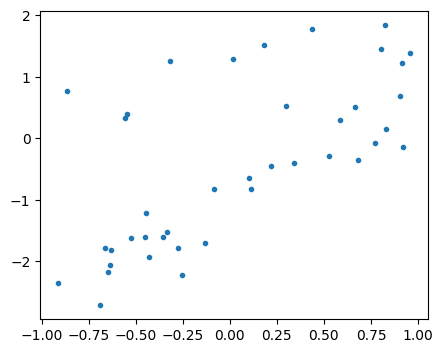

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5., 4.))
plt.plot(x, y, linestyle="", marker=".")
plt.show()

In [ ]:
n_chains = 5
n_groups = int(group_idx.max() + 1)
n_samples = 50_000

# Run MCMC
nuts_kernel = NUTS(hierarchical_linear_model)
mcmc = MCMC(
    nuts_kernel, 
    num_warmup=int(0.1 * n_samples), 
    num_samples=n_samples,
    num_chains=n_chains,
    progress_bar=True
)

key, subkey = jr.split(key)
mcmc.run(subkey, group_idx, x, n_groups, y_obs=y)
posterior_samples = mcmc.get_samples()

mcmc.print_summary()

jax.tree.map(jnp.shape, posterior_samples)

/var/folders/8t/4ygzv0nj53sdbz0dz587zwzh0000gq/T/ipykernel_54170/187555383.py:7: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample:  13%|█▎        | 7128/55000 [00:02<00:20, 2291.06it/s, 15 steps of size 3.78e-01. acc. prob=0.91]

In [ ]:
if n_chains > 1:
    posterior_samples = jax.tree.map(
        lambda a: jnp.reshape(a, (n_chains, n_samples, -1)), 
        posterior_samples
    )

In [ ]:
from numpyro.infer.util import log_density

def log_joint_from_params(params_i):
    logp_i, _ = log_density(
        hierarchical_linear_model,
        (group_idx, x, n_groups),
        dict(y_obs=y),
        params_i # i-th sample in j-th posterior chain
    )
    return logp_i

# vmap over leading dimension of each leaf
posterior_samples_log_probs = jnp.stack(
    [
        jax.vmap(
            lambda i: log_joint_from_params(
                {k: v[j, i, :] for k, v in posterior_samples.items()}
            )
        )(jnp.arange(n_samples)) for j in range(n_chains)
    ]
)
posterior_samples_log_probs.shape

(5, 50000)

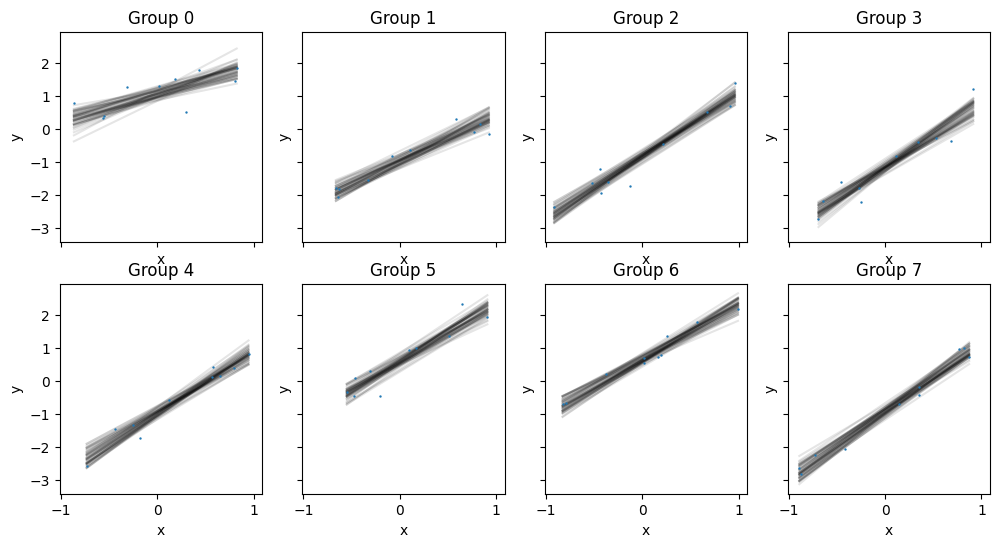

In [ ]:
import numpy as np 

n_lines = 50

fig, axs = plt.subplots(2, n_groups // 2, figsize=(1.5 * n_groups, 6), sharex=True, sharey=True)

for group_id in range(n_groups):
    ax = np.ravel(axs)[group_id]

    mask = (group_idx == group_id)
    x_g = x[mask]
    y_g = y[mask]

    # Sort x for prettier plotting
    order = jnp.argsort(x_g)
    x_sorted = x_g[order]
    y_sorted = y_g[order]

    # Grabbing first chain
    alpha_samples = posterior_samples["alpha"][0, :, group_id]
    beta_samples = posterior_samples["beta"][0, :, group_id]

    ax.scatter(x_sorted, y_sorted, label="data", zorder=3, s=0.5)

    # draw a bunch of posterior lines
    idx = jnp.arange(alpha_samples.shape[0])
    if n_lines < alpha_samples.shape[0]:
        idx = jr.choice(jr.key(123), idx, shape=(n_lines,), replace=False)

    for i in idx:
        a = alpha_samples[i]
        b = beta_samples[i]
        y_line = a + b * x_sorted
        ax.plot(x_sorted, y_line, alpha=0.1, color="k")

    ax.set_title(f"Group {group_id}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
plt.show()

In [ ]:
import pandas as pd

def make_df(samples, *, log_probs=None, parameter_strings=None):
    # Chainconsumer requires pd.Dataframe for chains
    if log_probs is None:
        log_probs = jnp.ones((samples.shape[0],))
    df = pd.DataFrame(samples, columns=parameter_strings)
    df = df.assign(log_posterior=jnp.ones((len(samples),)))
    return df

In [ ]:
alpha_samples = posterior_samples.pop("alpha")
beta_samples = posterior_samples.pop("beta")

print("Original")
print(list(posterior_samples.keys()))
print(list(truth.keys()))

# Ensure posterior and truth have same ordering of values w.r.t. parameter names
posterior_samples = dict(sorted(posterior_samples.items()))
truth = dict(sorted(truth.items()))

print("Sorted")
print(list(posterior_samples.keys()))
print(list(truth.keys()))

Original
['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'sigma_obs']
['mu_alpha', 'sigma_alpha', 'mu_beta', 'sigma_beta', 'sigma_obs']
Sorted
['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'sigma_obs']
['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'sigma_obs']


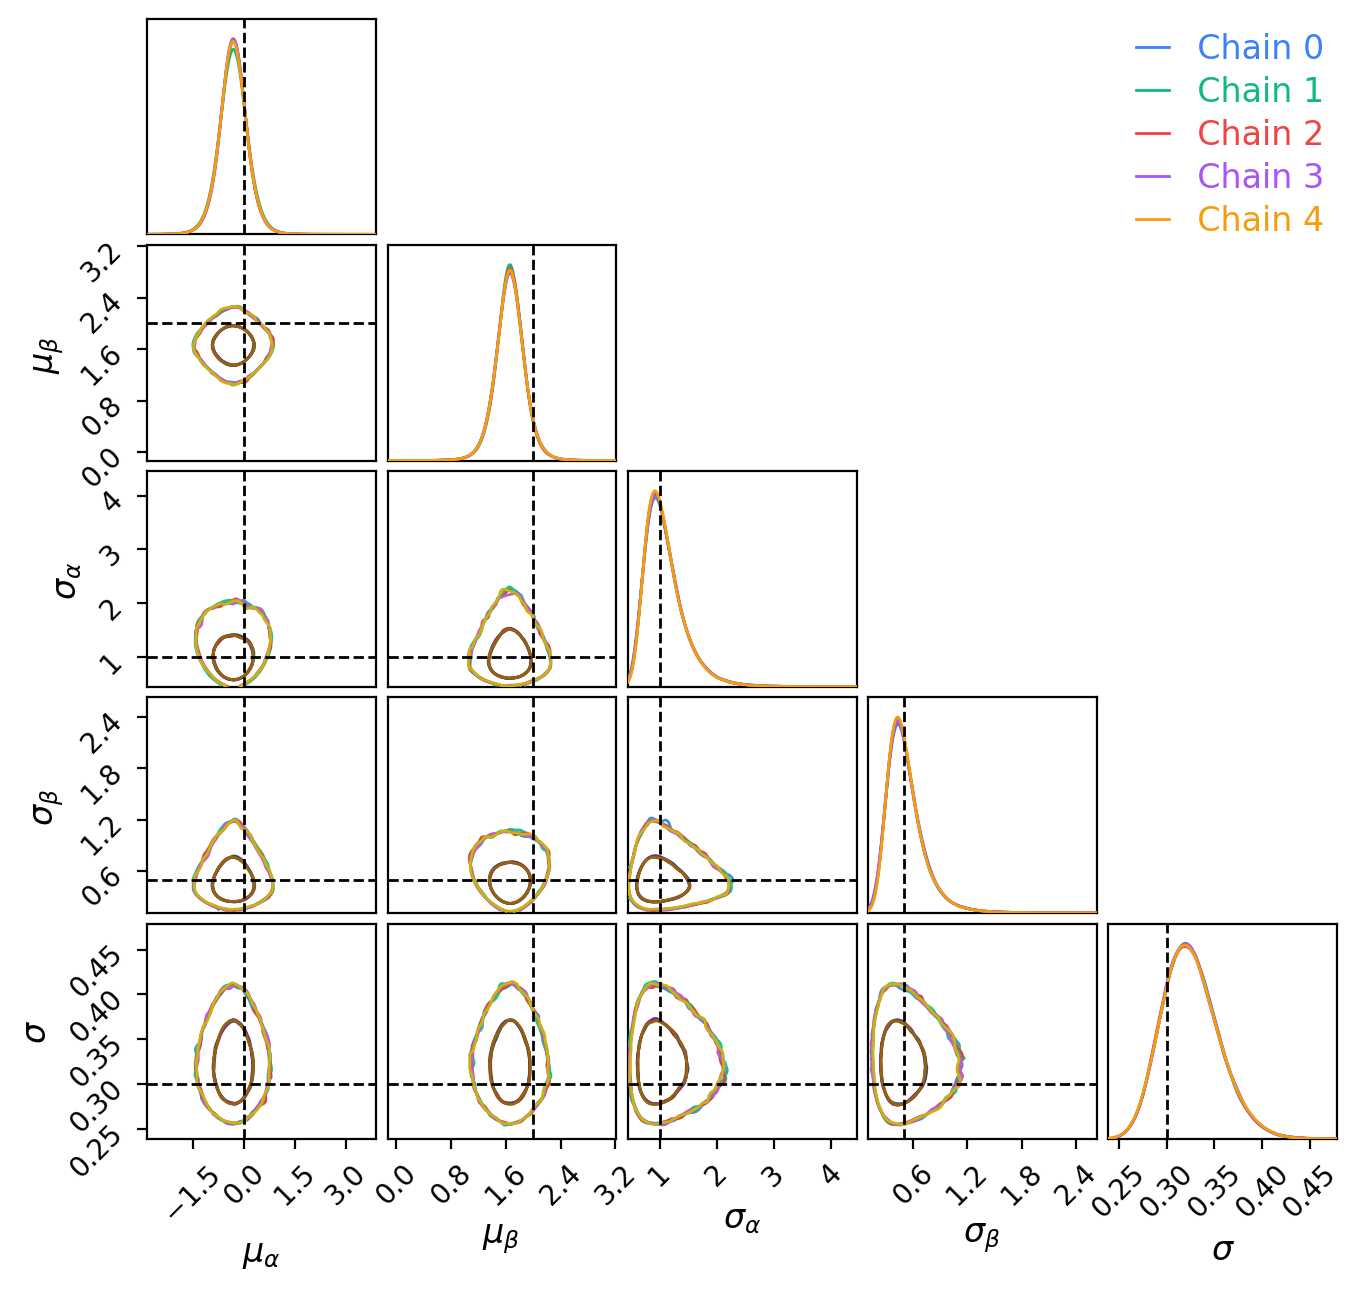

In [ ]:
from chainconsumer import ChainConsumer, Chain, Truth

labels = [r"$\mu_\alpha$", r"$\mu_\beta$", r"$\sigma_\alpha$", r"$\sigma_\beta$", r"$\sigma$"]

# Rename with Latex labels
posterior_samples = {k: v for k, v in zip(labels, posterior_samples.values())}
truth = {k: v for k, v in zip(labels, truth.values())}

c = ChainConsumer()

for n in range(n_chains):
    c.add_chain(
        Chain(
            samples=make_df(
                jnp.concatenate([p[n] for p in posterior_samples.values()], axis=1),
                log_probs=posterior_samples_log_probs[n],
                parameter_strings=truth.keys()
            ), 
            name="Chain {}".format(n)
        )
    )
c.add_truth(Truth(location=dict(zip(truth.keys(), list(truth.values())))))

fig = c.plotter.plot()
fig.set_figheight(7.)
fig.set_figwidth(7.)
fig.set_dpi(200)

plt.show()

In [ ]:
alpha_samples.shape, beta_samples.shape

((5, 50000, 8), (5, 50000, 8))

In [ ]:
alphas = {f"alpha_{i}": jnp.reshape(alpha_samples[:, :, i], (n_chains, n_samples, -1)) for i in range(n_groups)}
betas = {f"beta_{i}": jnp.reshape(beta_samples[:, :, i], (n_chains, n_samples, -1)) for i in range(n_groups)}

In [ ]:
full_posterior_samples = alphas | betas | posterior_samples
jax.tree.map(jnp.shape, full_posterior_samples)

{'$\\mu_\\alpha$': (5, 50000, 1),
 '$\\mu_\\beta$': (5, 50000, 1),
 '$\\sigma$': (5, 50000, 1),
 '$\\sigma_\\alpha$': (5, 50000, 1),
 '$\\sigma_\\beta$': (5, 50000, 1),
 'alpha_0': (5, 50000, 1),
 'alpha_1': (5, 50000, 1),
 'alpha_2': (5, 50000, 1),
 'alpha_3': (5, 50000, 1),
 'alpha_4': (5, 50000, 1),
 'alpha_5': (5, 50000, 1),
 'alpha_6': (5, 50000, 1),
 'alpha_7': (5, 50000, 1),
 'beta_0': (5, 50000, 1),
 'beta_1': (5, 50000, 1),
 'beta_2': (5, 50000, 1),
 'beta_3': (5, 50000, 1),
 'beta_4': (5, 50000, 1),
 'beta_5': (5, 50000, 1),
 'beta_6': (5, 50000, 1),
 'beta_7': (5, 50000, 1)}

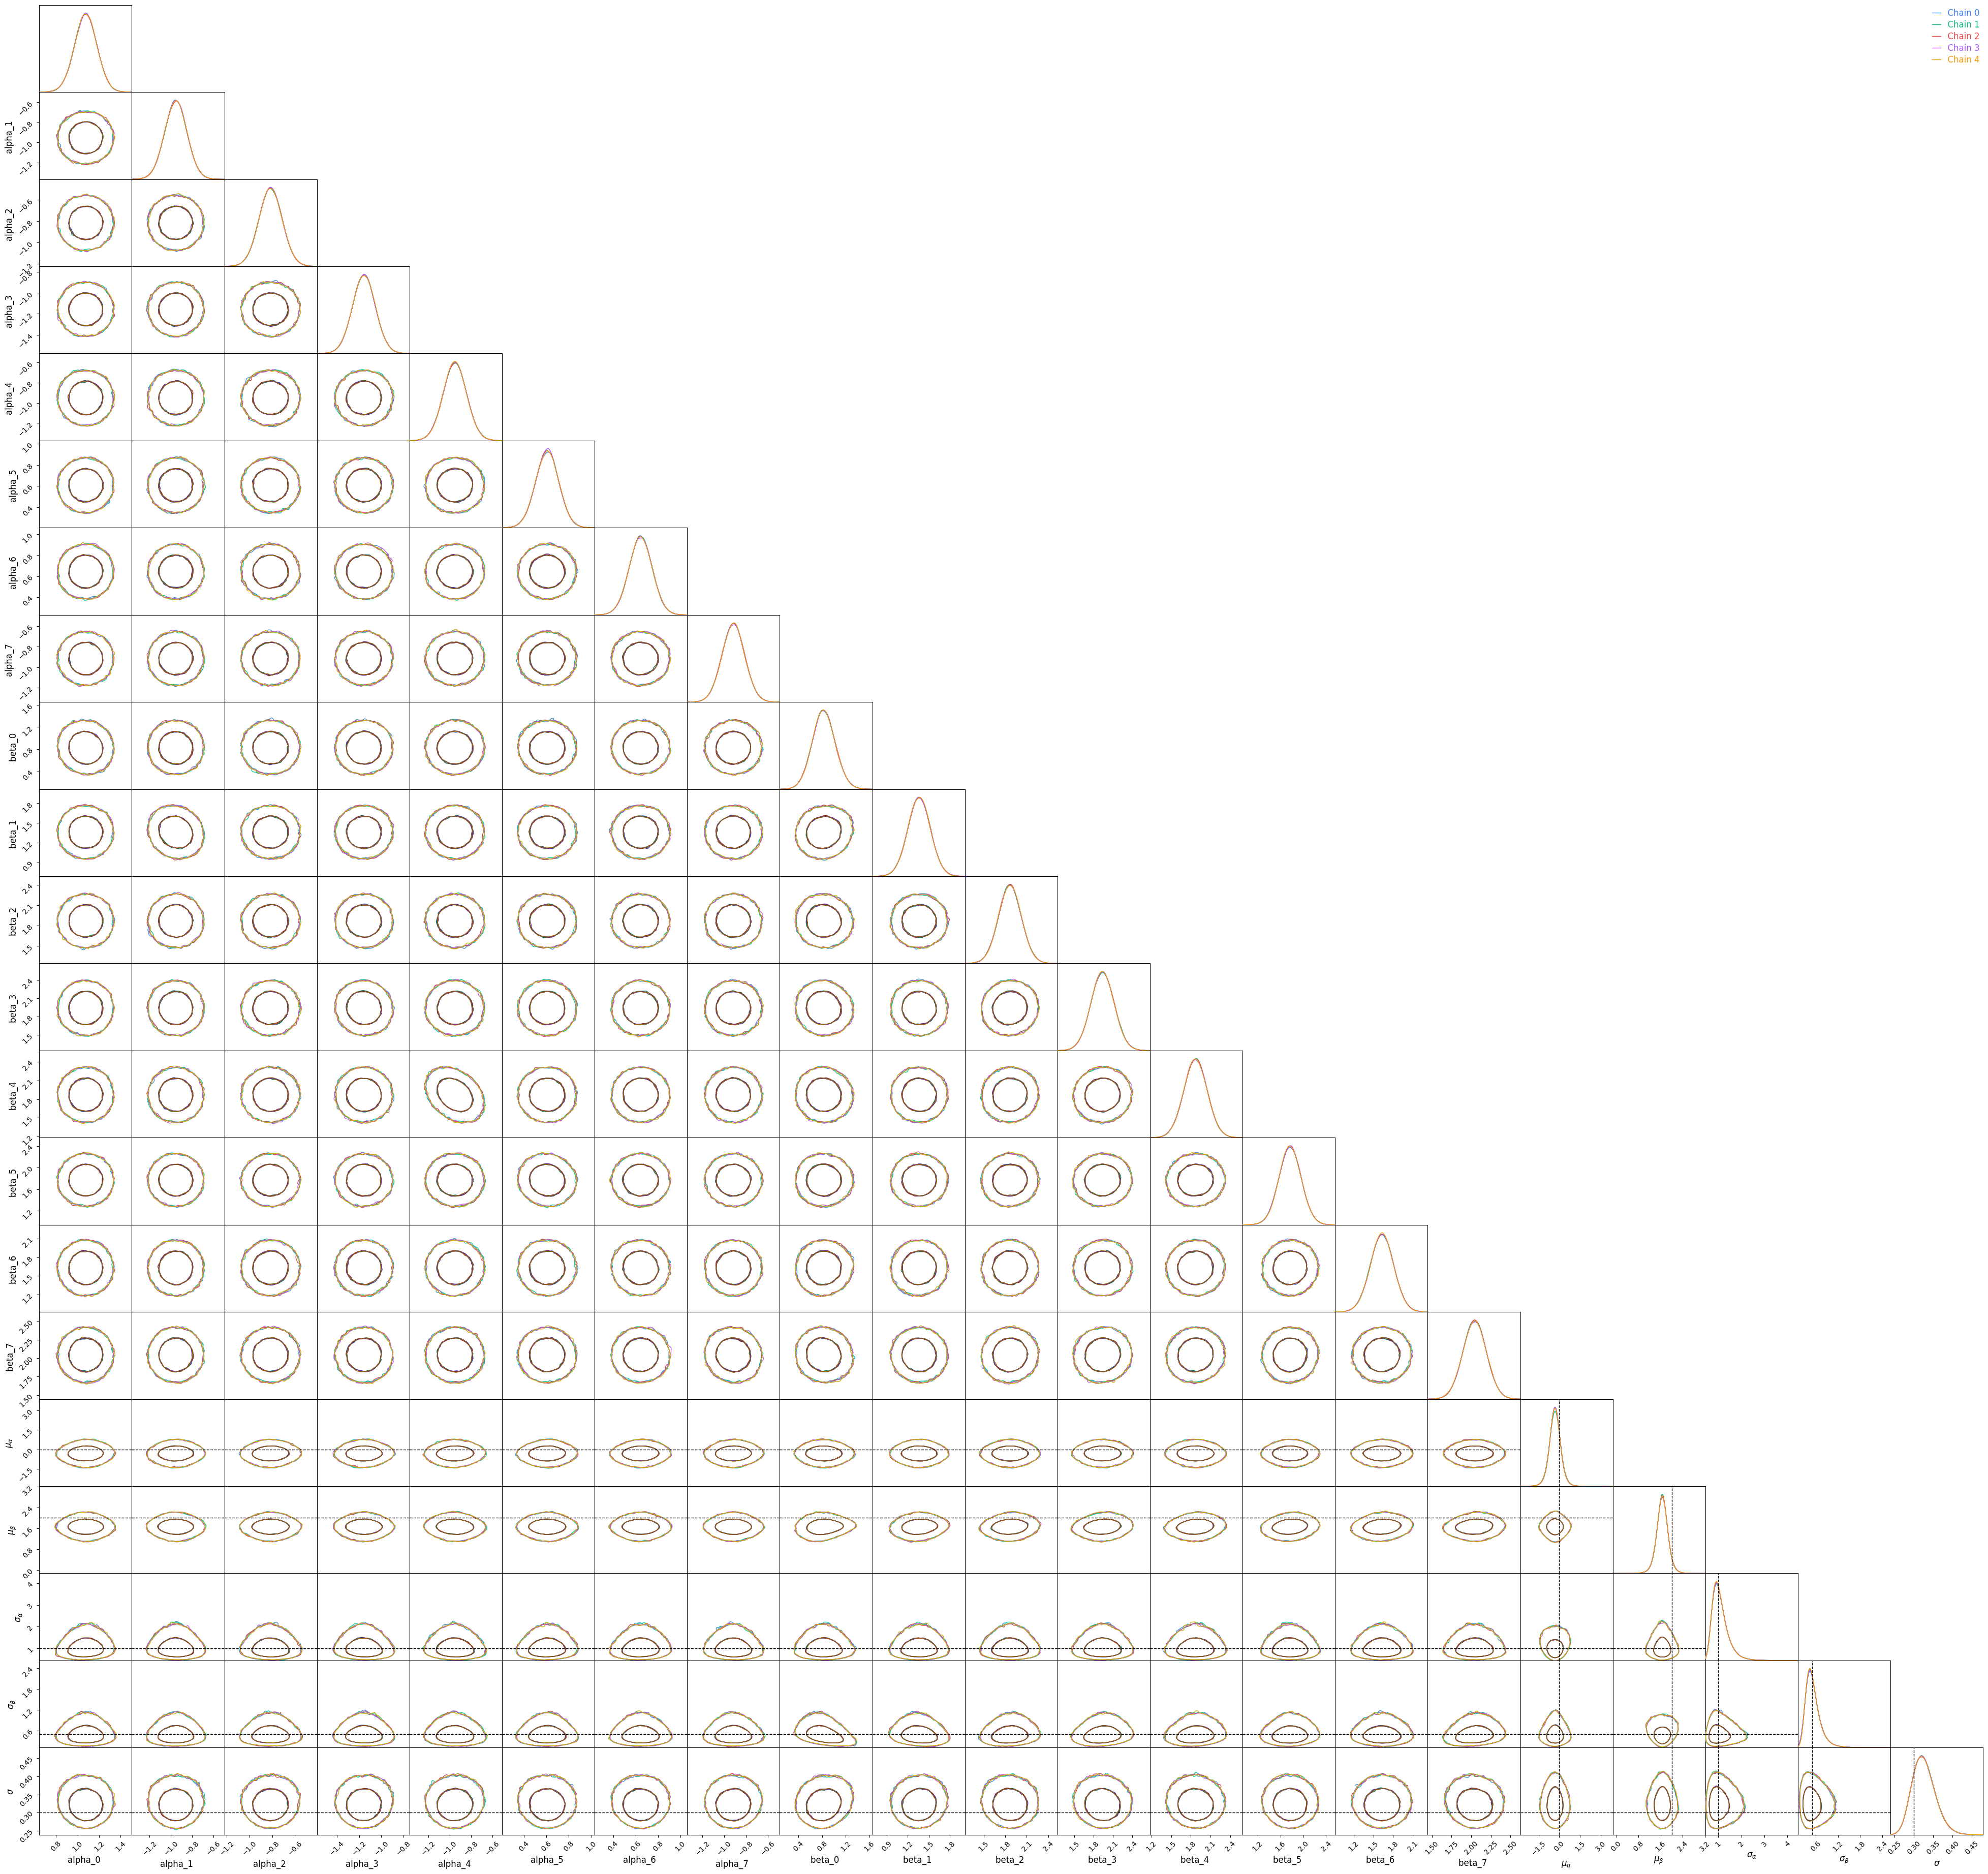

In [ ]:
from chainconsumer import ChainConsumer, Chain

c = ChainConsumer()

for n in range(n_chains):
    c.add_chain(
        Chain(
            samples=make_df(
                jnp.concatenate([p[n] for p in full_posterior_samples.values()], axis=1),
                log_probs=posterior_samples_log_probs[n],
                parameter_strings=full_posterior_samples.keys()
            ), 
            name="Chain {}".format(n)
        )
    )
c.add_truth(Truth(location=dict(zip(truth.keys(), list(truth.values())))))

fig = c.plotter.plot()
fig.set_figheight(7.)
fig.set_figwidth(7.)
fig.set_dpi(200)

plt.show()